<a href="https://colab.research.google.com/github/Archi-Ahsan/mL/blob/main/210151_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)


In [2]:
url = "https://raw.githubusercontent.com/Archi-Ahsan/mL/refs/heads/main/heart.csv"
data = pd.read_csv(url)

data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:

print("Columns in dataset:\n", data.columns)

columns_to_drop = ['id', 'Unnamed: 32']
data.drop(columns=[col for col in columns_to_drop if col in data.columns],
          inplace=True)

target_column = 'target'

X = data.drop(target_column, axis=1)
y = data[target_column]

X = X.fillna(X.mean())

X = pd.get_dummies(X, drop_first=True)

print("\nFinal feature shape:", X.shape)
print("Target shape:", y.shape)


Columns in dataset:
 Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

Final feature shape: (1025, 13)
Target shape: (1025,)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)


Train size: (717, 13)
Validation size: (154, 13)
Test size: (154, 13)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


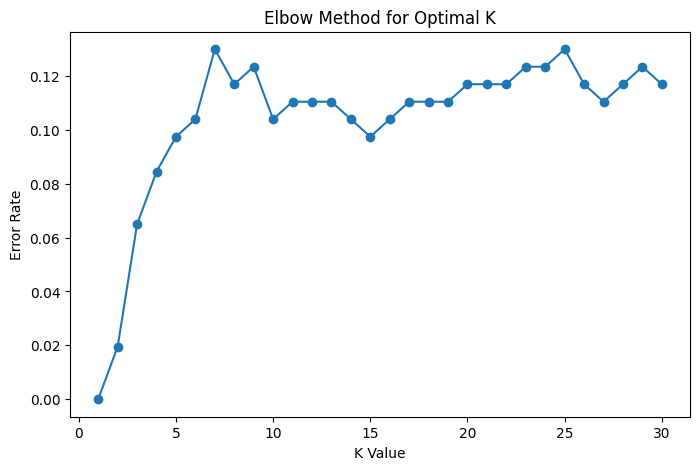

In [7]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt

error_rate = []

for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_val = knn.predict(X_val)
    error_rate.append(np.mean(pred_val != y_val))

plt.figure(figsize=(8,5))
plt.plot(range(1, 31), error_rate, marker='o')
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.title('Elbow Method for Optimal K')
plt.show()


In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'distance'}


In [9]:
best_knn = grid.best_estimator_
best_knn.fit(X_train, y_train)


KNeighborsClassifier(metric='manhattan', n_neighbors=23, weights='distance')

In [10]:
y_pred = best_knn.predict(X_test)
y_prob = best_knn.predict_proba(X_test)[:, 1]


In [11]:
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("AUC      :", roc_auc_score(y_test, y_prob))


Accuracy : 0.9805194805194806
Precision: 1.0
Recall   : 0.9620253164556962
F1 Score : 0.9806451612903225
AUC      : 1.0


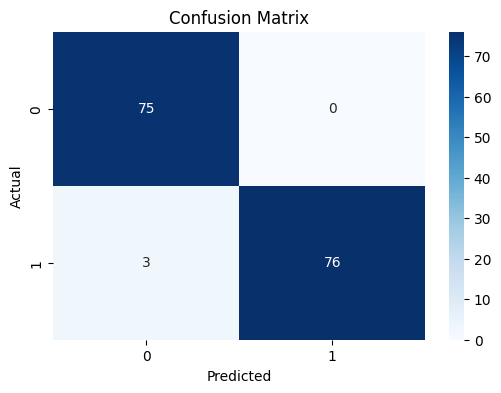

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


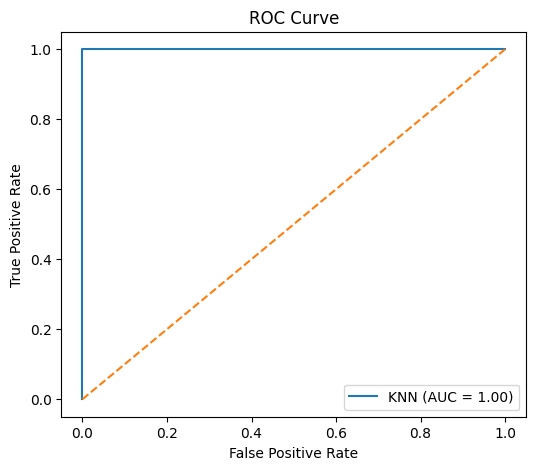

In [13]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label='KNN (AUC = %.2f)' % roc_auc_score(y_test, y_prob))
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


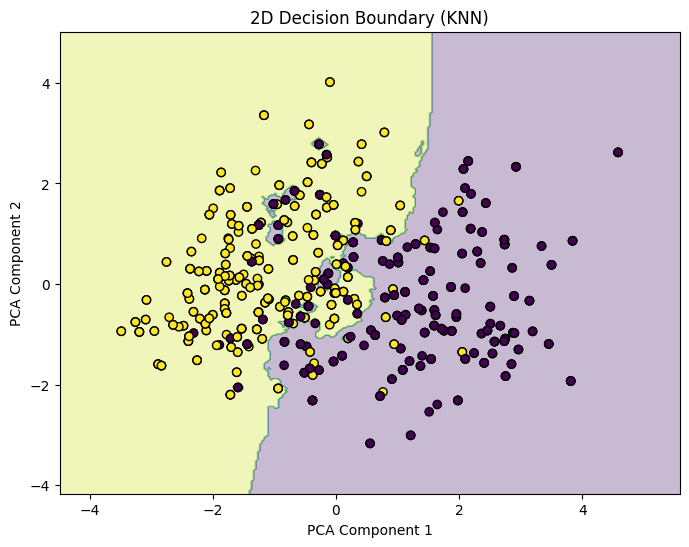

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

knn_2d = KNeighborsClassifier(
    n_neighbors=grid.best_params_['n_neighbors'],
    weights=grid.best_params_['weights'],
    metric=grid.best_params_['metric']
)
knn_2d.fit(X_train_pca, y_train)

x_min, x_max = X_train_pca[:,0].min()-1, X_train_pca[:,0].max()+1
y_min, y_max = X_train_pca[:,1].min()-1, X_train_pca[:,1].max()+1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D Decision Boundary (KNN)')
plt.show()
